In [1]:
# !apt update
# !apt install python3.12 python3.12-dev python3.12-venv
# !update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.12 2
# !update-alternatives --config python3

In [2]:
!python3 -V # Версия Python

Python 3.12.3


In [3]:
import torch
import torchtext
print(f"PyTorch version: {torch.__version__}")
print(f"TorchText version: {torchtext.__version__}")

PyTorch version: 2.3.1+cu121
TorchText version: 0.18.0+cpu


In [4]:
import torch
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


/home/lad1chka/myenv/lib/python3.12/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/lad1chka/myenv/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/lad1chka/myenv/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TOR

In [5]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 256
NUM_HEADS = 4
EMBED_DIM = 128
FF_DIM = 256
NUM_LAYERS = 2
NUM_EPOCHS = 5
LR = 1e-4

In [6]:
train_iter, test_iter = IMDB(split=('train', 'test'))

tokenizer = get_tokenizer('basic_english')

# Построение словаря
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])

# Обработка текста
def text_pipeline(text):
    tokens = tokenizer(text)
    tokens = tokens[:MAX_SEQ_LEN-2]
    tokens = ['<bos>'] + tokens + ['<eos>']
    ids = vocab(tokens)
    if len(ids) < MAX_SEQ_LEN:
        ids = ids + [vocab['<pad>']] * (MAX_SEQ_LEN - len(ids))
    else:
        ids = ids[:MAX_SEQ_LEN]
    return ids

def label_pipeline(label):
    return int(label) - 1

In [7]:
# Создание датасета
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, data_iter):
        self.data = []
        for label, text in data_iter:
            self.data.append((text_pipeline(text), label_pipeline(label)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return np.array(self.data[idx][0]), np.array(self.data[idx][1])

train_dataset = IMDBDataset(train_iter)
test_dataset = IMDBDataset(test_iter)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print("Example:")
print("Text:", train_dataset[0][0][:10], "...")
print("Label:", train_dataset[0][1])

Train samples: 25000
Test samples: 25000
Example:
Text: [    2    15  1570    15   248 35470    45    66   400  1137] ...
Label: 0


In [9]:
# Компоненты трансформера
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)]
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        q = self.W_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.W_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.W_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)

        output = torch.matmul(attn_weights, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(output)

        return output, attn_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, mask=None):
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)

        ff_output = self.ff(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)

        return x, attn_weights

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, MAX_SEQ_LEN)
        self.layers = nn.ModuleList([TransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.linear = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, return_attn=False):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        attn_weights_list = []
        for layer in self.layers:
            x, attn_weights = layer(x)
            attn_weights_list.append(attn_weights)

        x = x.mean(dim=1)

        x = self.linear(x)

        if return_attn:
            return x, attn_weights_list
        return x

In [10]:
# Инициализация
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerClassifier(
    vocab_size=len(vocab),
    d_model=EMBED_DIM,
    num_heads=NUM_HEADS,
    d_ff=FF_DIM,
    num_layers=NUM_LAYERS,
    num_classes=2
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Обучение
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in loader:
        inputs, labels = batch
        inputs = torch.from_numpy(np.array(inputs)).long().to(device)
        labels = torch.from_numpy(np.array(labels)).long().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs = torch.from_numpy(np.array(inputs)).long().to(device)
            labels = torch.from_numpy(np.array(labels)).long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("Обучение")
print("-" * 50)
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print("-" * 50)

Обучение
--------------------------------------------------


/tmp/ipykernel_7691/1932379899.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inputs = torch.from_numpy(np.array(inputs)).long().to(device)
/tmp/ipykernel_7691/1932379899.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  labels = torch.from_numpy(np.array(labels)).long().to(device)
/tmp/ipykernel_7691/1932379899.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy

Epoch 1/5
Train Loss: 0.6624 | Train Acc: 57.87%
Val Loss: 0.5898 | Val Acc: 69.01%
--------------------------------------------------
Epoch 2/5
Train Loss: 0.5259 | Train Acc: 73.34%
Val Loss: 0.4949 | Val Acc: 75.56%
--------------------------------------------------
Epoch 3/5
Train Loss: 0.4636 | Train Acc: 77.48%
Val Loss: 0.4538 | Val Acc: 78.49%
--------------------------------------------------
Epoch 4/5
Train Loss: 0.4350 | Train Acc: 79.78%
Val Loss: 0.4343 | Val Acc: 79.84%
--------------------------------------------------
Epoch 5/5
Train Loss: 0.4094 | Train Acc: 81.45%
Val Loss: 0.4149 | Val Acc: 80.63%
--------------------------------------------------


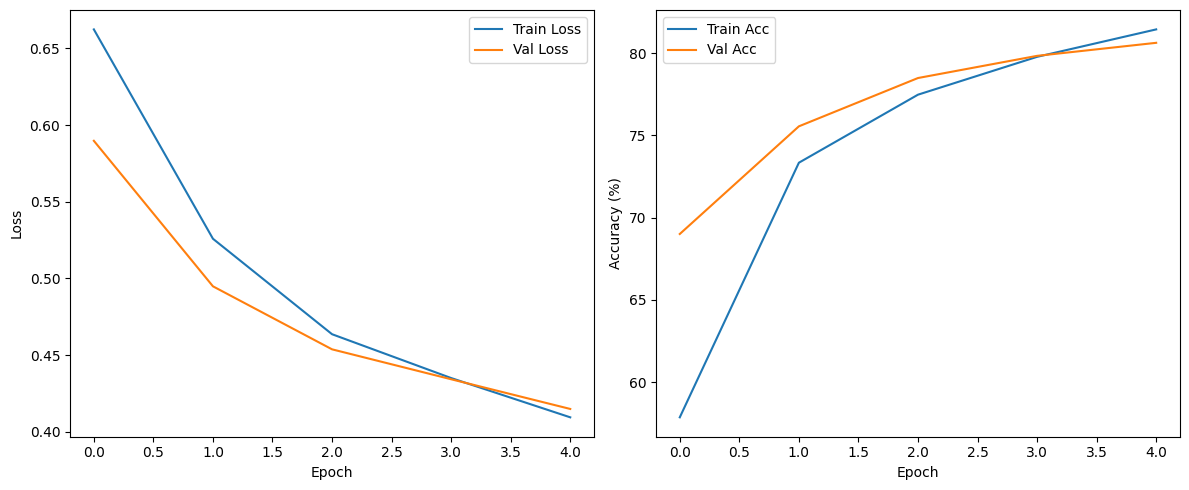

In [11]:
# Визуализация обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

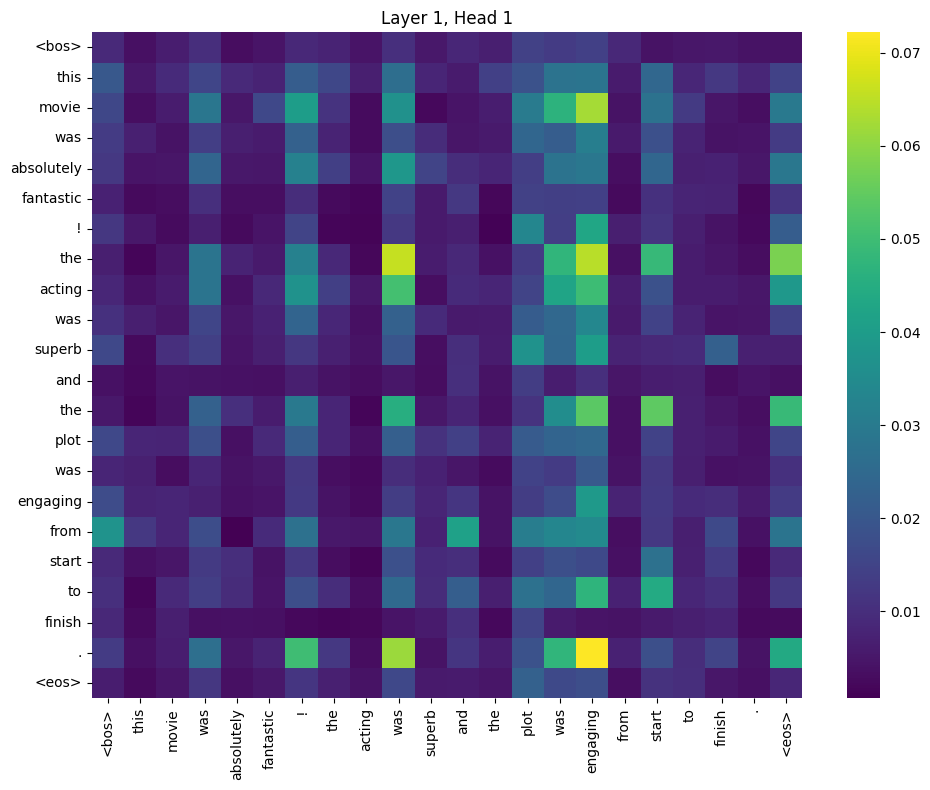

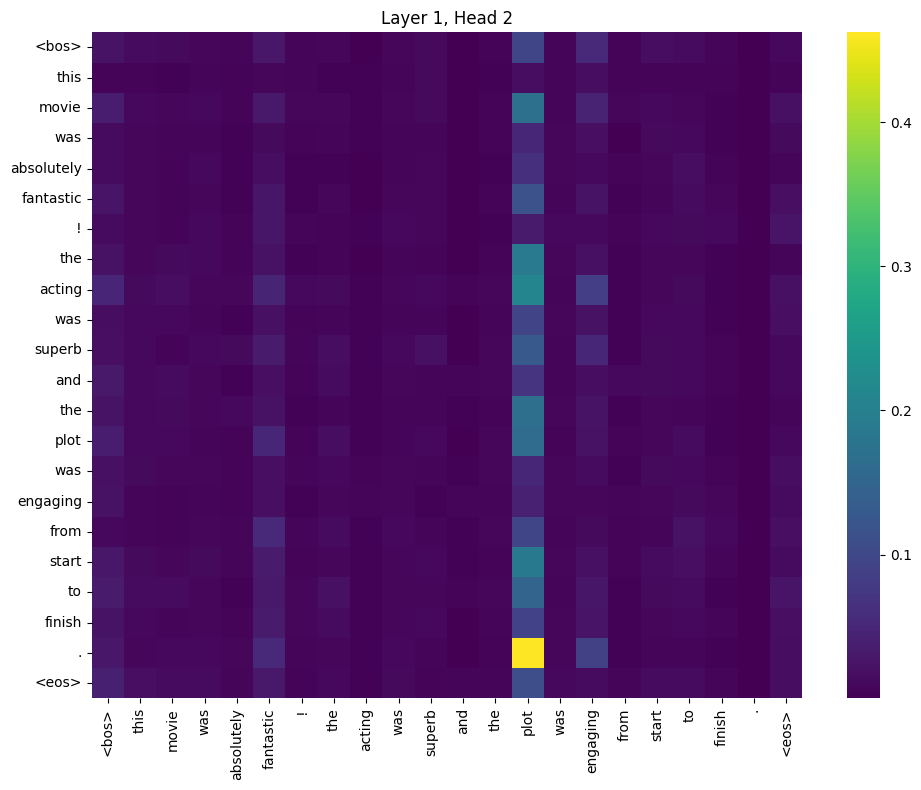

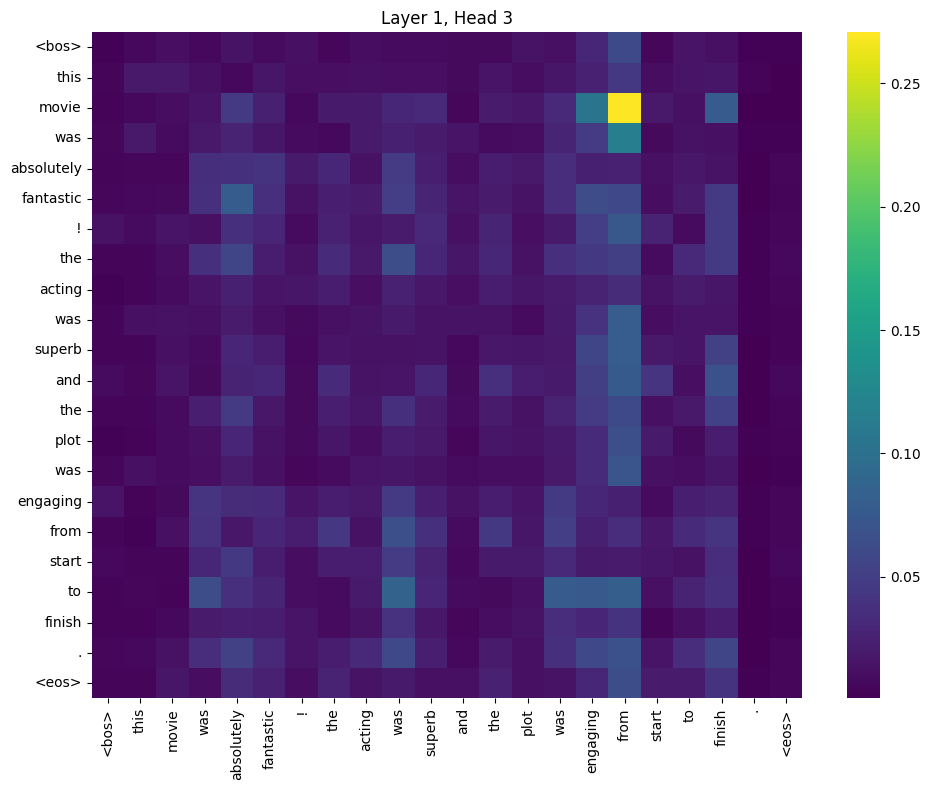

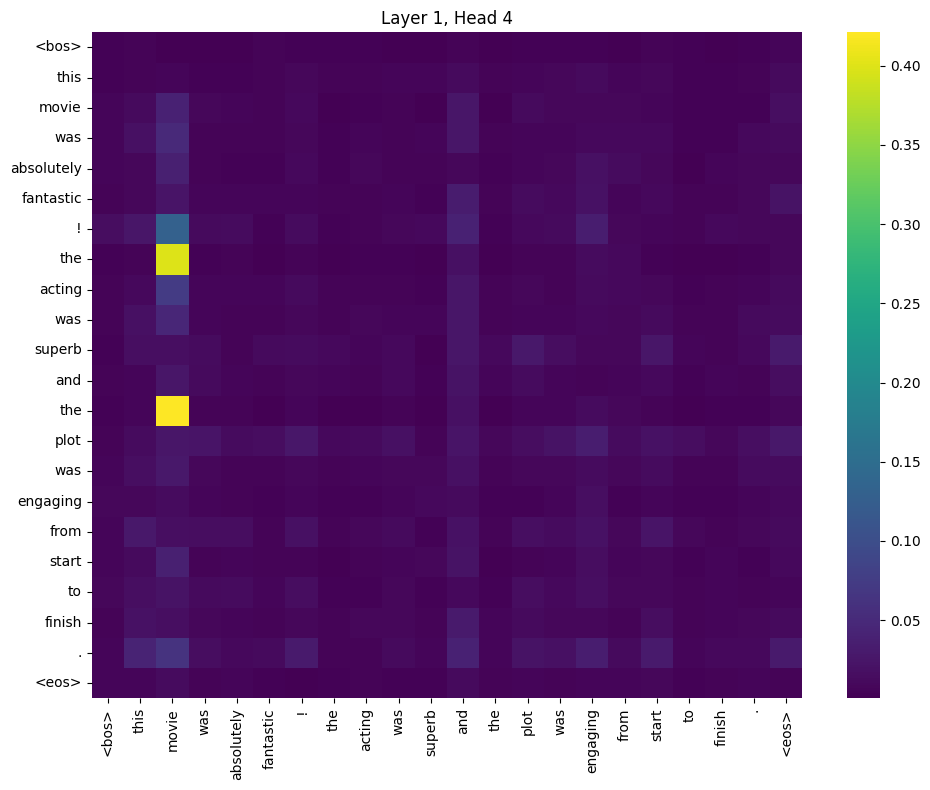

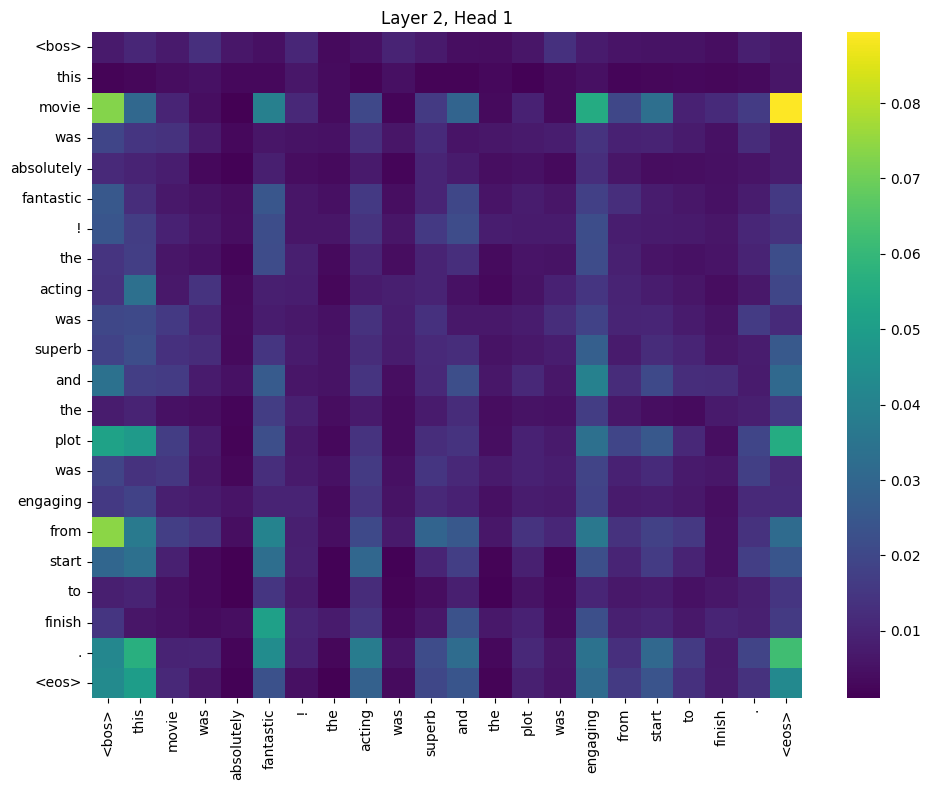

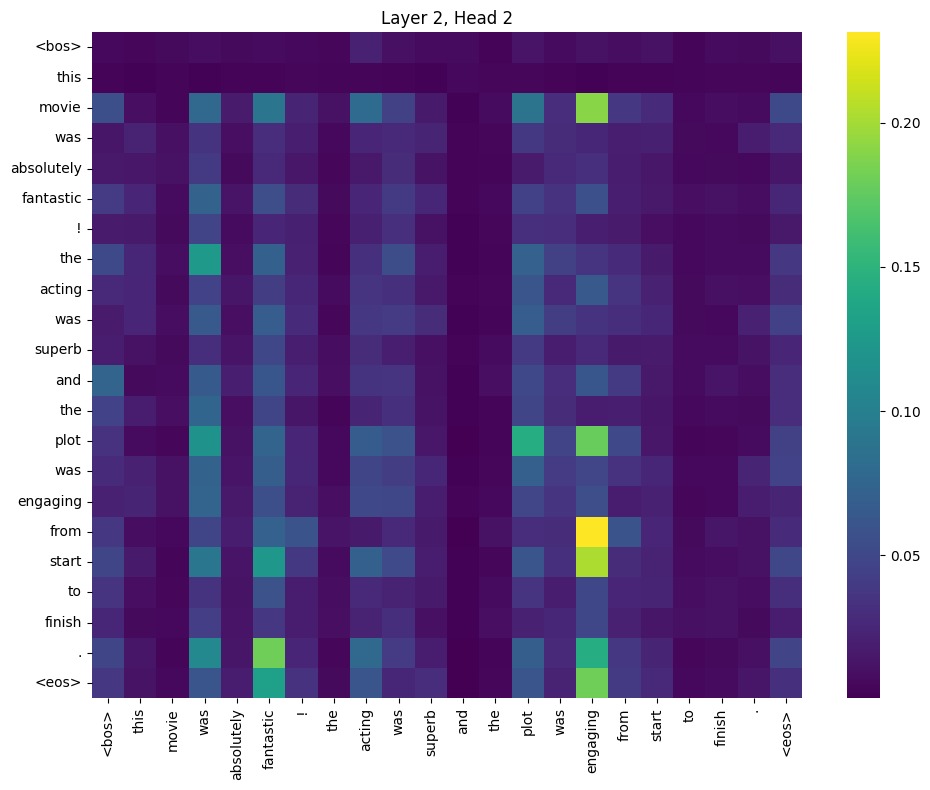

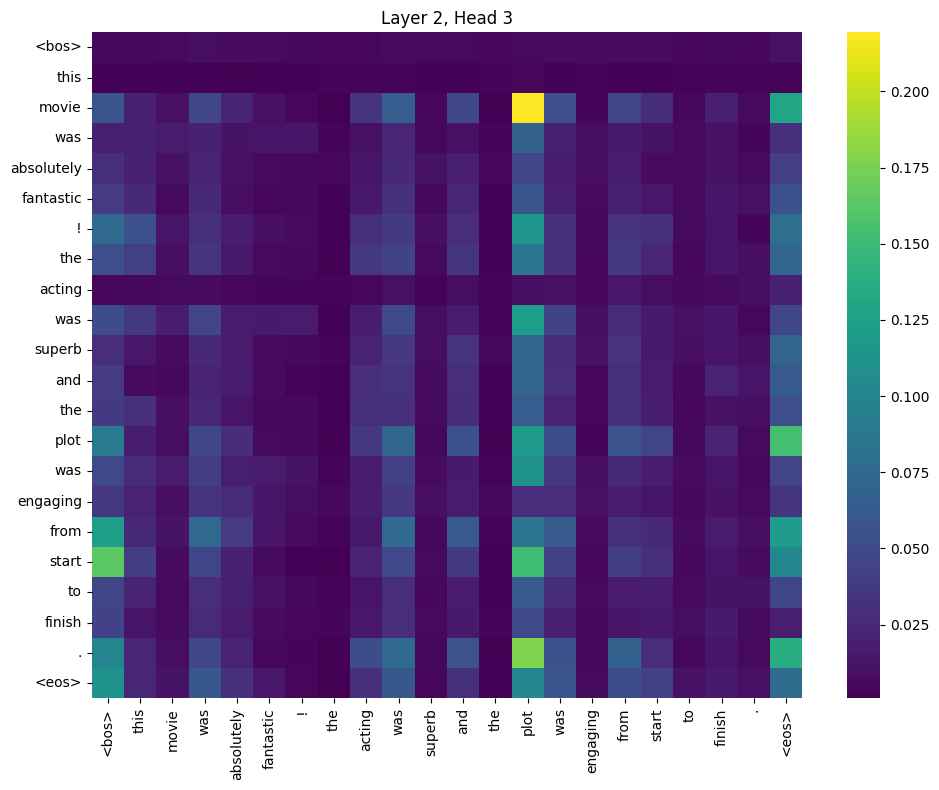

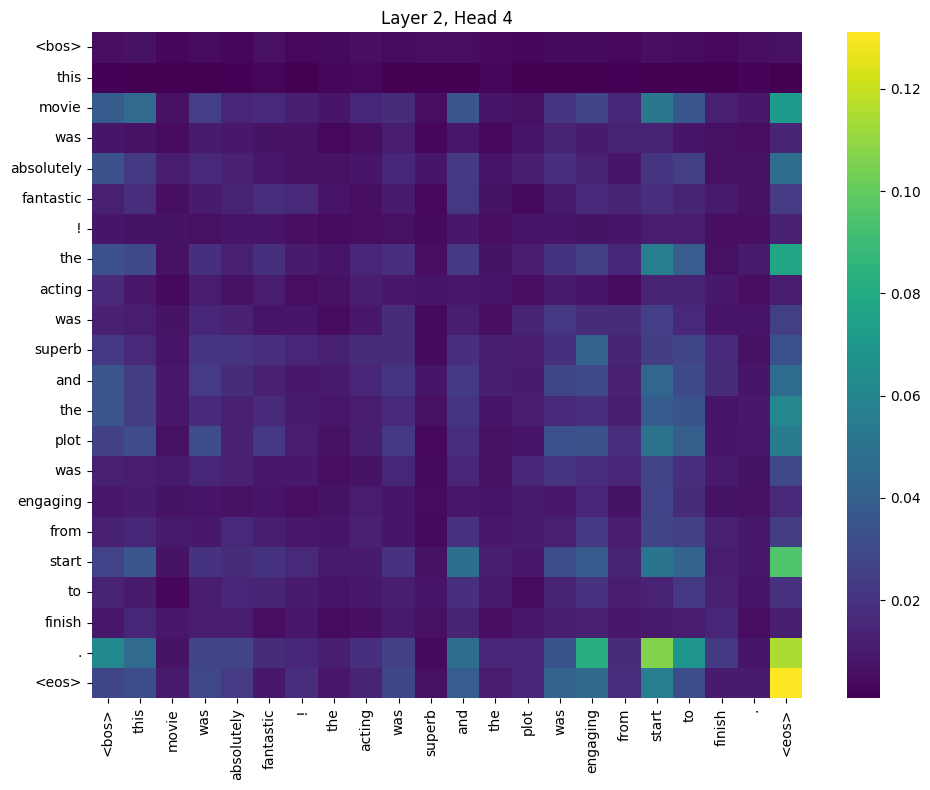

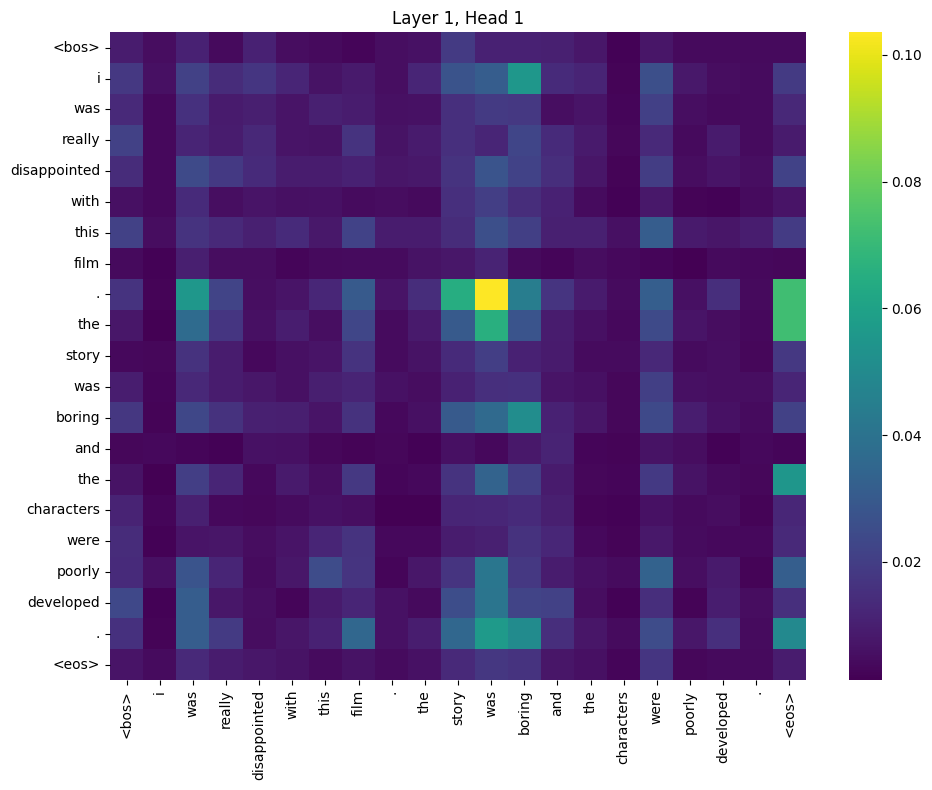

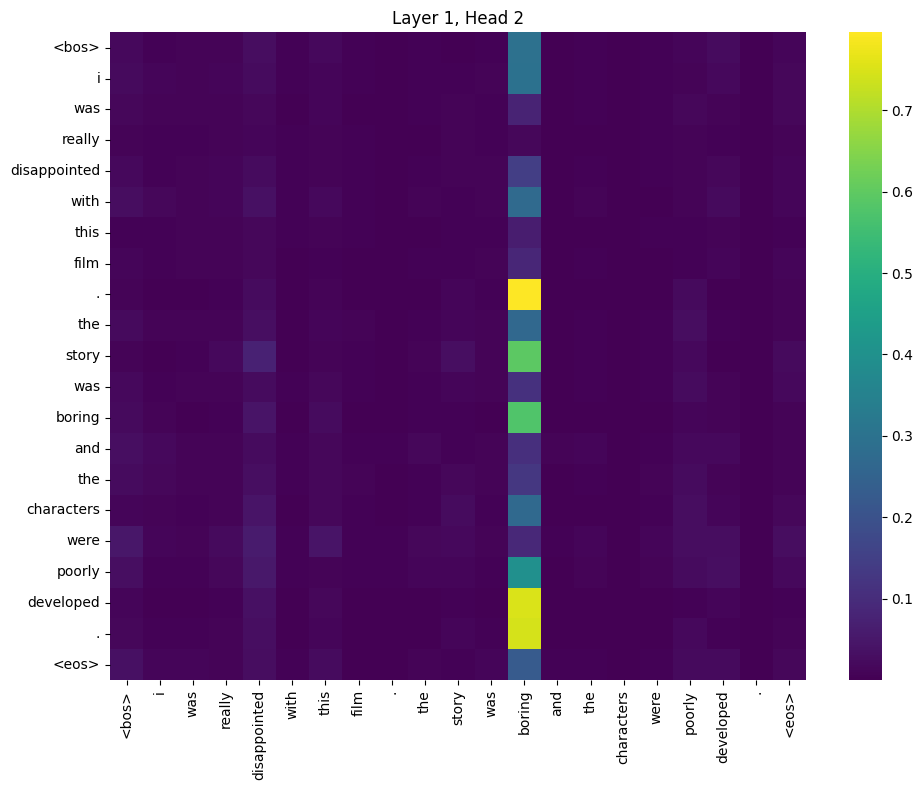

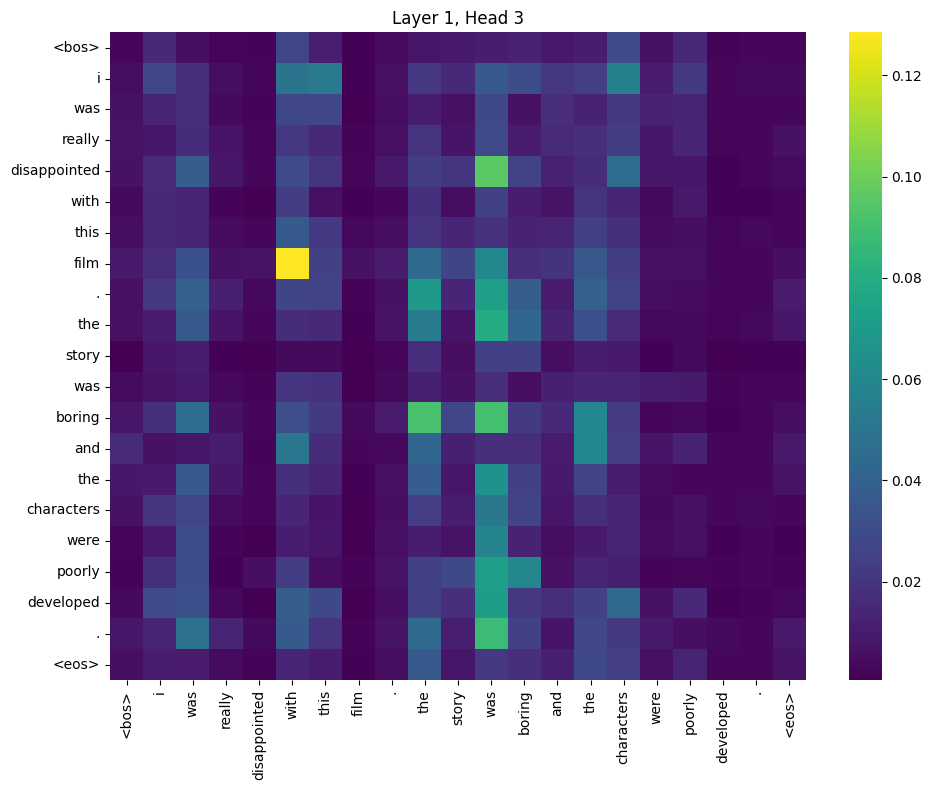

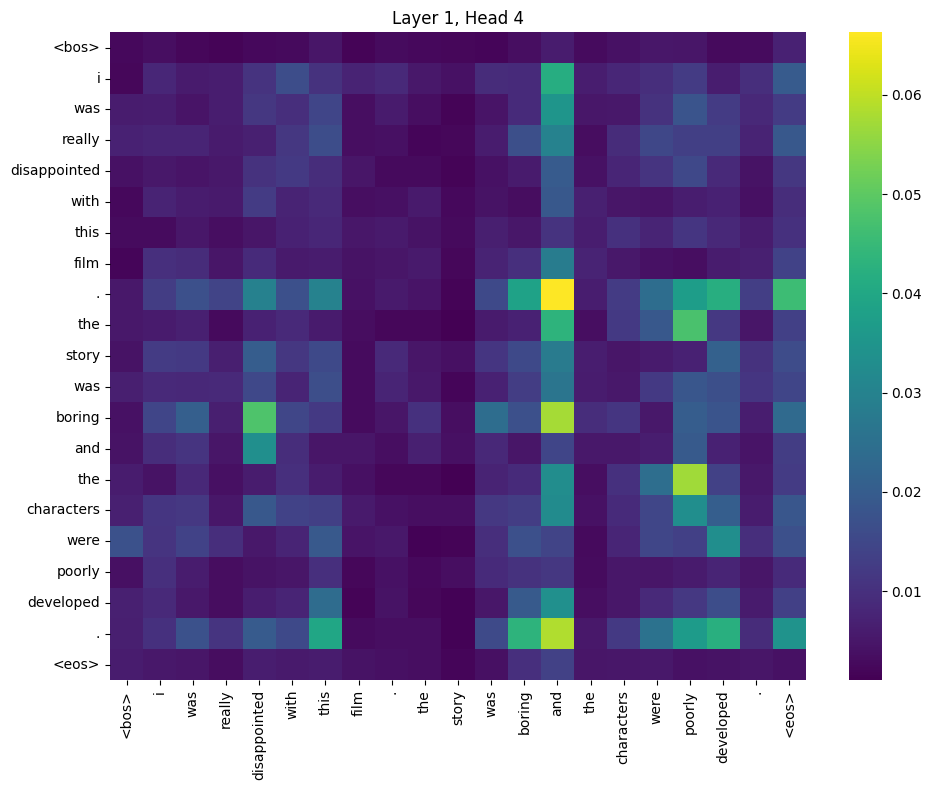

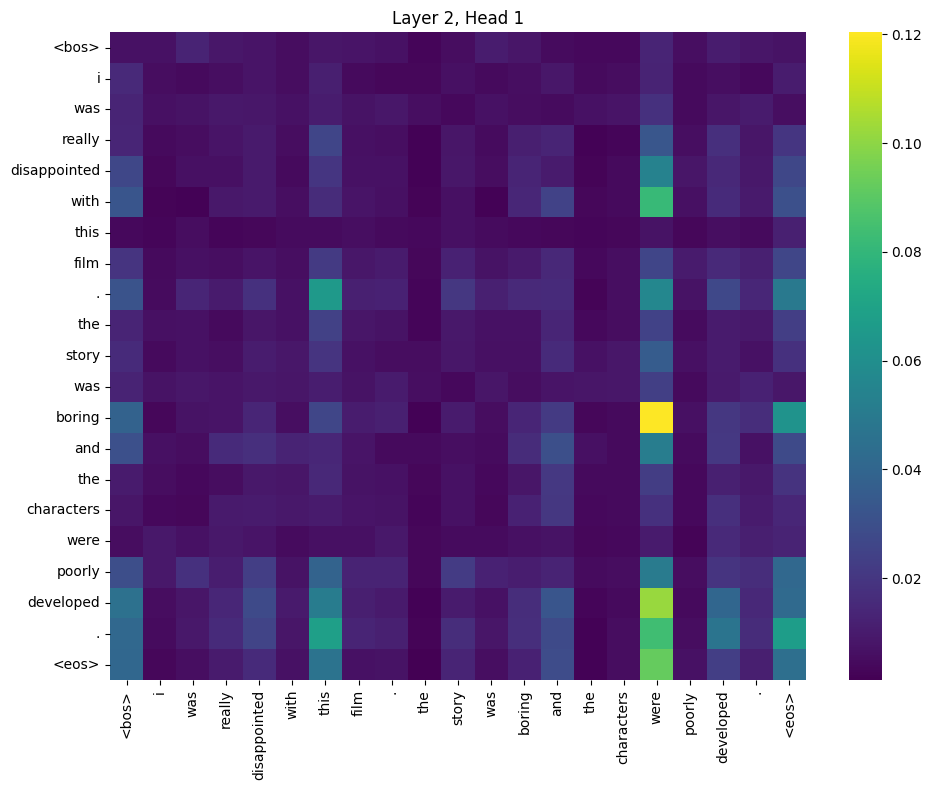

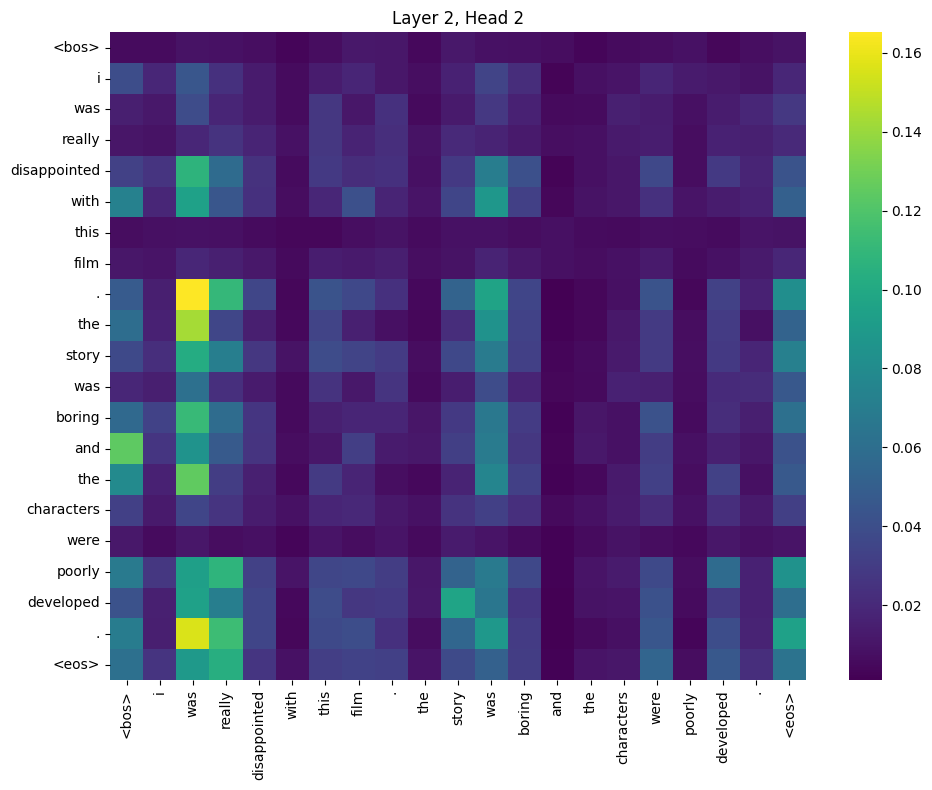

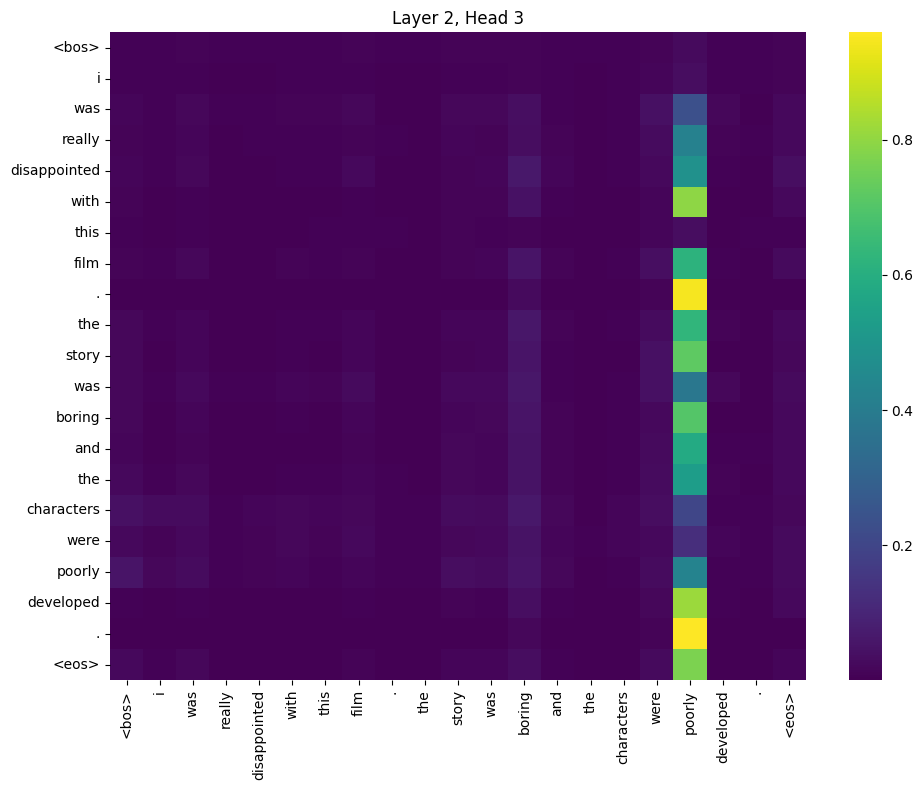

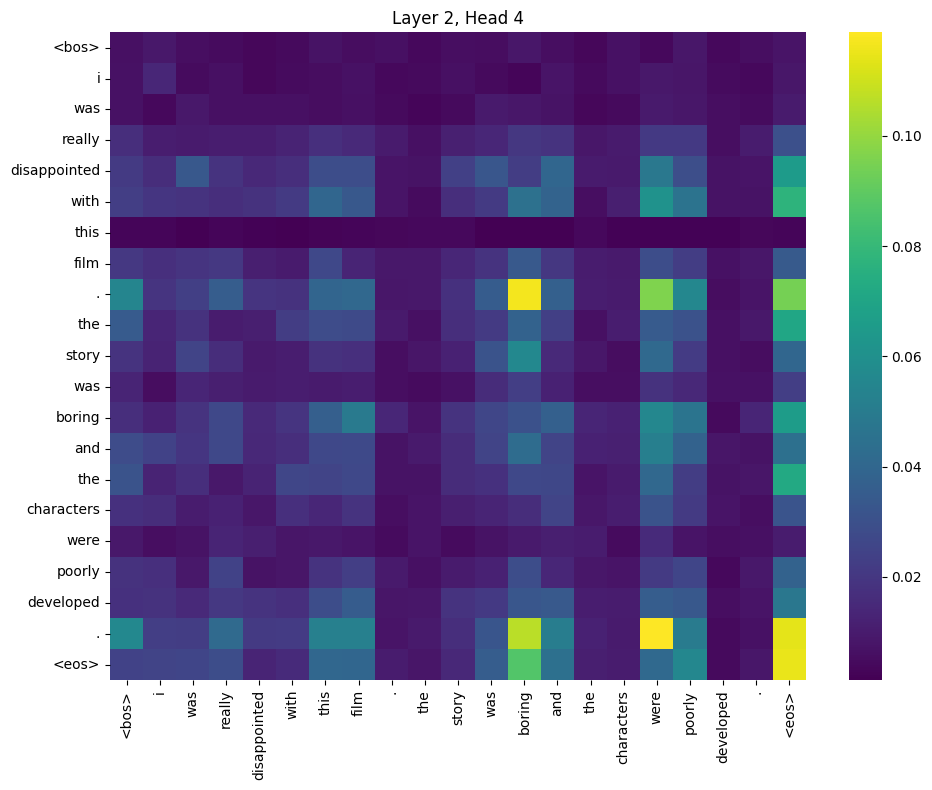

In [13]:
def visualize_attention(text, model, vocab, tokenizer, max_len=MAX_SEQ_LEN):
    # Подготовка текста
    tokens = tokenizer(text)
    tokens = tokens[:max_len-2]
    tokens = ['<bos>'] + tokens + ['<eos>']
    ids = vocab(tokens)

    if len(ids) < max_len:
        ids = ids + [vocab['<pad>']] * (max_len - len(ids))
    else:
        ids = ids[:max_len]

    input_tensor = torch.tensor([ids]).to(device)
    _, attn_weights_list = model(input_tensor, return_attn=True)

    # Визуализация для каждого слоя и каждой головы
    for layer_idx, attn_weights in enumerate(attn_weights_list):
        attn_weights = attn_weights.squeeze(0).cpu().detach().numpy()
        for head_idx in range(attn_weights.shape[0]):
            plt.figure(figsize=(10, 8))
            sns.heatmap(attn_weights[head_idx][:len(tokens), :len(tokens)],
                        cmap='viridis',
                        xticklabels=tokens,
                        yticklabels=tokens)
            plt.title(f"Layer {layer_idx+1}, Head {head_idx+1}")
            plt.xticks(rotation=90)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

# Примеры
sample_text = "This movie was absolutely fantastic! The acting was superb and the plot was engaging from start to finish."
visualize_attention(sample_text, model, vocab, tokenizer)
sample_text_neg = "I was really disappointed with this film. The story was boring and the characters were poorly developed."
visualize_attention(sample_text_neg, model, vocab, tokenizer)